## 필요한 모듈 import

In [58]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

## 데이터 불러오기

In [3]:
path = glob.glob(r'C:\rsDataset\Mudy_Crack\*')
label = glob.glob(r'C:\rsDataset\Mudy_Crack_json\*')

## json 파싱, mask 생성

In [136]:
for i in range(len(label)):
    mask_name=label[i].split("\\")[-1][:-5]
    with open(label[i], 'r')as f:
        sample = json.load(f)
    points_mat= np.zeros((180,180))
    bound=[]
    for j in range(len(sample['shapes'])):
        if sample['shapes'][j]['label']== 'crack' : 
            for points_ in sample['shapes'][j]['points']:
                x_, y_= points_[0],points_[1]
                bound.append([x_,y_])
    cnt=np.array(bound).reshape((-1,1,2)).astype(np.int32)
    cv2.fillPoly(points_mat,[cnt],255)
    cv2.imwrite(f'C:/rsDataset/Mudy_Crack_mask/{mask_name}.png',points_mat)

## 생성된 mask 확인 ( label[확인하고자하는 순서])

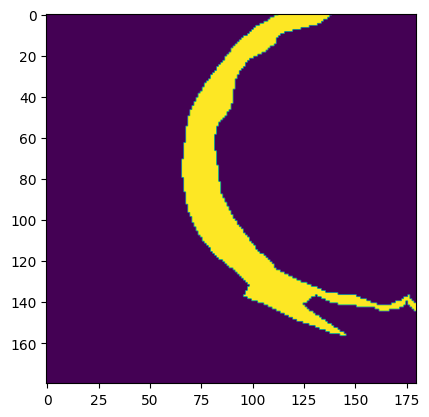

In [127]:
with open(label[0], 'r')as f: ## label[변경]
    sample = json.load(f)
points_mat= np.zeros((180,180))
bound=[]
for j in range(len(sample['shapes'])):
    if sample['shapes'][j]['label']== 'crack' : 
        for points_ in sample['shapes'][j]['points']:
            x_, y_= points_[0],points_[1]
            bound.append([x_,y_])
cnt=np.array(bound).reshape((-1,1,2)).astype(np.int32)
cv2.fillPoly(points_mat,[cnt],255)
plt.imshow(points_mat)

## 1. 원본img와 생성된 마스크img 각각 읽어들이기 
## 2. 읽어들인 img,mask 전처리 하기(normalize 또는 필요하면 resize)
## 3. segmentation model 구축
## 4. segmentation 모델의 input으로 (img,mask) fitting 시키기
## 5. 학습결과 확인 및 test set으로 inference해 보기

### 1. 원본img와 생성된 마스크img 각각 읽어들이기

### 2. 읽어들인 img,mask 전처리 하기(normalize 또는 필요하면 resize)

In [ ]:
##classification에서 사용했던 전처리 함수입니다. 수정필
# def preprocessing_cell(path, label):
#     x_train=[]
#     y_train=[]
#     image_path=glob.glob(path+'/*.jpg')
#     for x in image_path :
#             img=load_img(x, target_size=(180,180))
#             img=img_to_array(img)
#             img=img/255.0
#             x_train.append(img)
#             y_train.append(label)
#     return np.array(x_train),np.array(y_train)

In [ ]:
# cell, cell_y  = preprocessing_cell(r'C:\rcvDataset\cell', 0)
# crackcell, crackcell_y  = preprocessing_cell(r'C:\rcvDataset\crackcell', 1)
# #rod, rod_y  = preprocessing_rod(r'C:\rcvDataset\rod\rod', 2)

### loss 정의

In [2]:
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### 3. segmentation model 구축

## 아래는 기본 U-Net입니다. segmentation을 위한 또 다른 네트워크가 많으니 baseline으로 두시고 여러가지 적용 해 보시기 바랍니다!

In [6]:
from tensorflow.keras.layers import Concatenate

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [7]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 256, 256, 32) 128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 32) 9248        batch_normalization_12[0][0]     
_______________________________________________________________________________________

### 4. segmentation 모델의 input으로 (img,mask) fitting 시키기

In [ ]:
# build the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('unet.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 5. 학습결과 확인 및 test set으로 inference해 보기